In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

intron_annot = pd.read_csv('../data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)
#long_table = pd.read_csv("../code/ReadLengthMapExperimentResults/JuncCountsTidy/LongTable.txt.gz", sep='\t')
long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]#.assay.unique()

Let's see how many junctions and junction reads we have in total.

In [2]:
total_rows = long_table.shape[0]
total_junctions = long_table[['chrom', 'start', 'stop', 'strand']].drop_duplicates().shape[0]
total_junction_reads = long_table.Count.sum()

print('total rows:', total_rows)
print('total junctions:', total_junctions)
print('total junction reads:', total_junction_reads)

total rows: 58456464
total junctions: 2794291
total junction reads: 3649127025


In [3]:
# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])


# long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'end', 'strand', 'gene', 'NewAnnotation'], 
#                  right_on=['chrom', 'start', 'end', 'strand', 'gene', 'NewAnnotation'])



One concern is that not all junctions might appear in Yang's annotation. The annotation seems to be done on the trimmed and remapped junctions (maybe it's not...), so many junctions seem to be missing. This might be due to the fact that the longer reads are better at finding new splice junctions. Now let's see how many introns and counts we have left.

In [4]:
filtered_rows = long_table.shape[0]
filtered_junctions = long_table[['chrom', 'start', 'stop', 'strand']].drop_duplicates().shape[0]
filtered_junction_reads = long_table.Count.sum()

print('filtered rows:', filtered_rows)
print('filtered junctions:', filtered_junctions)
print('filtered junction reads:', filtered_junction_reads)

filtered rows: 47701031
filtered junctions: 351668
filtered junction reads: 3616671648


In [5]:
fraction_rows_kept = 100*(filtered_rows/total_rows)
fraction_junctions_kept = 100*(filtered_junctions/total_junctions)
fraction_reads_kept = 100*(filtered_junction_reads/total_junction_reads)

print("fraction rows kept: {:.2f}".format(fraction_rows_kept) + '%')
print("fraction junctions kept: {:.2f}".format(fraction_junctions_kept) + '%')
print("fraction reads kept: {:.2f}".format(fraction_reads_kept) + '%')

fraction rows kept: 81.60%
fraction junctions kept: 12.59%
fraction reads kept: 99.11%


Ok, so less than 1% of reads are actually removed. I won't concern too much about it for now.

Let's define some functions to process the long table and obtain percent of NMD junctions easily. These are not the cleanest, but they will suffice for now.

In [6]:
def longtable_by_annotation(long_table):
    counts_by_annotation = long_table.groupby(['Dataset', 'IndID', 'SuperAnnotation']).Count.sum().reset_index()
    counts_by_semiannotation = long_table.groupby(
        ['Dataset', 'IndID', 'SemiSupergroupAnnotations']
    ).Count.sum().reset_index()
    return counts_by_annotation, counts_by_semiannotation

def get_junction_types(counts_by_annotation, counts_by_semiannotation):
    
    counts = counts_by_annotation.groupby(['Dataset', 'IndID']).Count.sum().reset_index()
    counts.columns = ['Dataset', 'IndID', 'total_counts']

    assay = []
    for i in counts.Dataset:
        if i == 'chRNA.Expression.Splicing':
            assay.append('chRNA')
        elif i == 'Expression.Splicing':
            assay.append('polyA')
        elif i == 'MetabolicLabelled.30min':
            assay.append('4sU 30min')
        elif i == 'MetabolicLabelled.60min':
            assay.append('4sU 60min')

    counts['assay'] = assay

    Protein_coding_counts = np.array(counts_by_annotation.loc[counts_by_annotation.SuperAnnotation.isin(
        ['AnnotatedJunc_UnproductiveCodingGene',
         'UnannotatedJunc_UnproductiveCodingGene',
         'AnnotatedJunc_ProductiveCodingGene',
         'UnannotatedJunc_ProductiveCodingGene'])].groupby(['Dataset', 'IndID']).Count.sum())

    Unproductive_counts = np.array(counts_by_annotation.loc[counts_by_annotation.SuperAnnotation.isin(
        ['AnnotatedJunc_UnproductiveCodingGene',
         'UnannotatedJunc_UnproductiveCodingGene'])].groupby(['Dataset', 'IndID']).Count.sum())

    Productive_counts = np.array(counts_by_annotation.loc[counts_by_annotation.SuperAnnotation.isin(
        ['AnnotatedJunc_ProductiveCodingGene',
         'UnannotatedJunc_ProductiveCodingGene'])].groupby(['Dataset', 'IndID']).Count.sum())

#     Noncoding_counts = np.array(counts_by_annotation.loc[counts_by_annotation.SuperAnnotation.isin(
#         ['AnnotatedJunc_NoncodingGene',
#          'UnannotatedJunc_NoncodingGene'])].groupby(['Dataset', 'IndID']).Count.sum())
    
    
    Annotated_NMD_counts = np.array(counts_by_semiannotation.loc[counts_by_semiannotation.SemiSupergroupAnnotations.isin(
        ['uniquely nonsense_mediated_decay tag'])].groupby(['Dataset', 'IndID']).Count.sum())
    
    unprod_annotations = ['uniquely processed_transcript tag',
       'overlaps processed transcript intron',
       'uniquely retained_intron tag', 'predicted_NMD pstopcodon',
       'predicted_NMD far3p', 'uniquely nonsense_mediated_decay tag',
       'predicted_NMD UTRjunction', 'predicted_NMD YN',
       'predicted_NMD far5p', 'predicted_NMD reason2',
       'overlaps retained_intron tag', 'stable.NY',
       'overlaps nonsense_mediated_decay intron',
       'uniquely non_stop_decay tag', 'predicted_NMD reason1',
       'predicted_NMD NN']

    predicted_annot = [x for x in unprod_annotations if ('predicted_NMD' in x)]

    try:
        Unannotated_NMD_counts = np.array(counts_by_semiannotation.loc[counts_by_semiannotation.SemiSupergroupAnnotations.isin(
            predicted_annot)].groupby(['Dataset', 'IndID']).Count.sum())

        counts['Unannotated_NMD'] = 100*(Unannotated_NMD_counts/Protein_coding_counts)
    except:
        print('No unannotated NMD')

    Annotated_pt_counts = np.array(counts_by_semiannotation.loc[counts_by_semiannotation.SemiSupergroupAnnotations.isin(
        ['uniquely processed_transcript tag'])].groupby(['Dataset', 'IndID']).Count.sum())
    
    counts['Unproductive_juncs'] = 100*(Unproductive_counts/Protein_coding_counts)
    counts['Productive_juncs'] = 100*(Productive_counts/Protein_coding_counts)
#     counts['Noncoding_juncs'] = 100*(Noncoding_counts/counts.total_counts)

    counts['Annotated_NMD'] = 100*(Annotated_NMD_counts/Protein_coding_counts)
    
    counts['Processed_transcripts'] = 100*(Annotated_pt_counts/Protein_coding_counts)
    
    other_unproductive_annot = [x for x in unprod_annotations if (x not in [
        'uniquely processed_transcript tag', 'uniquely nonsense_mediated_decay tag'] + predicted_annot)]
    
    other_unproductive = np.array(counts_by_semiannotation.loc[counts_by_semiannotation.SemiSupergroupAnnotations.isin(
            other_unproductive_annot)].groupby(['Dataset', 'IndID']).Count.sum())
    
    counts['other_unproductive'] = 100*(other_unproductive/Protein_coding_counts)
    
    

    order = ['chRNA', '4sU 30min', '4sU 60min', 'polyA']
    
    return counts, order

def longtable_to_boxplot(long_table):
    
    counts_by_annotation, counts_by_semiannotation = longtable_by_annotation(long_table)
    counts, order = get_junction_types(counts_by_annotation, counts_by_semiannotation)
    
    return counts, order

In [7]:
del intron_annot
counts, order = longtable_to_boxplot(long_table)

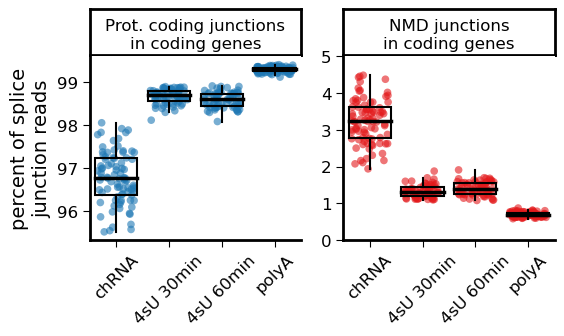

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = counts, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.6, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.6, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
ax[1,1].set_ylim([0, 5])
# ax[1,0].set_ylim([95, 100.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')

ax[1, 1].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)


plt.show()

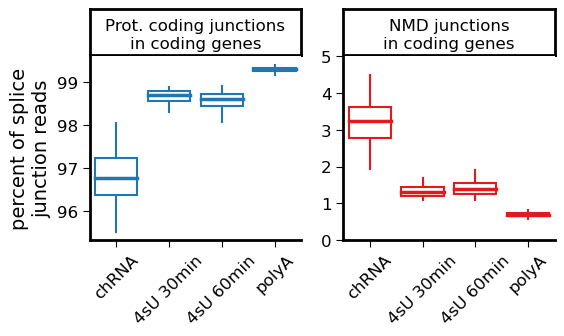

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = counts, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

sns.boxplot(data = counts, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
ax[1,1].set_ylim([0, 5])
# ax[1,0].set_ylim([95, 100.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')

ax[1, 1].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)

plt.show()

In [10]:
median_unproductive_chRNA = counts.loc[counts.assay == 'chRNA'].Unproductive_juncs.median()
median_unproductive_ml30 = counts.loc[counts.assay == '4sU 30min'].Unproductive_juncs.median()
median_unproductive_ml60 = counts.loc[counts.assay == '4sU 60min'].Unproductive_juncs.median()
median_unproductive_polyA = counts.loc[counts.assay == 'polyA'].Unproductive_juncs.median()

print("NMD junctions in protein coding genes, in chRNA: {:.2f}".format(median_unproductive_chRNA) + '%')
print("NMD junctions in protein coding genes, in 4sU 30min: {:.2f}".format(median_unproductive_ml30) + '%')
print("NMD junctions in protein coding genes, in 4sU 60min: {:.2f}".format(median_unproductive_ml60) + '%')
print("NMD junctions in protein coding genes, in polyA: {:.2f}".format(median_unproductive_polyA) + '%')

NMD junctions in protein coding genes, in chRNA: 3.24%
NMD junctions in protein coding genes, in 4sU 30min: 1.30%
NMD junctions in protein coding genes, in 4sU 60min: 1.39%
NMD junctions in protein coding genes, in polyA: 0.69%


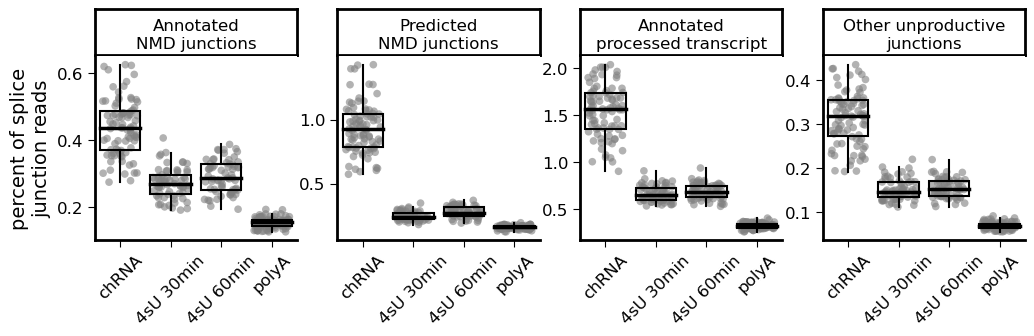

In [11]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = counts, x = 'assay', y = 'Annotated_NMD', jitter=0.35, ax=ax[1, 0], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Annotated_NMD', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Unannotated_NMD', jitter=0.35, ax=ax[1, 1], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Unannotated_NMD', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Processed_transcripts', jitter=0.35, ax=ax[1, 2], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Processed_transcripts', width=0.8, ax=ax[1, 2], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'other_unproductive', jitter=0.35, ax=ax[1, 3], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'other_unproductive', width=0.8, ax=ax[1, 3], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(4):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(4):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    


ax[1, 0].set_title('Annotated\nNMD junctions')
ax[1, 1].set_title('Predicted\nNMD junctions')
ax[1, 2].set_title('Annotated\nprocessed transcript')#, y=1.0, pad=12)
ax[1, 3].set_title('Other unproductive\njunctions')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 3].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
ax[1,2].tick_params(length=5, labelsize=12)
ax[1,3].tick_params(length=5, labelsize=12)

plt.show()

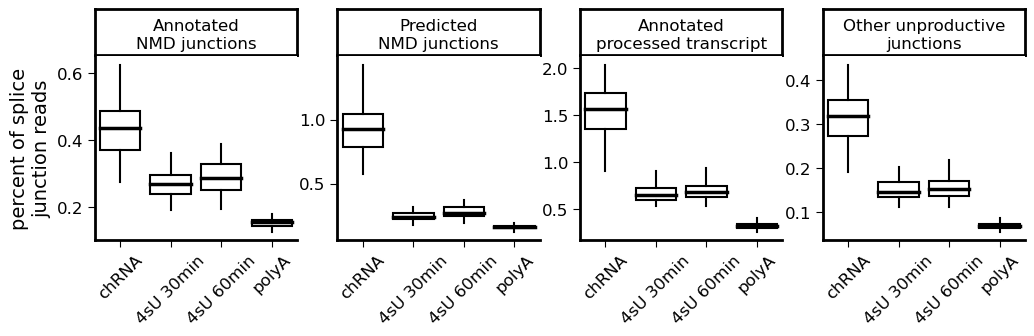

In [12]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})

sns.boxplot(data = counts, x = 'assay', y = 'Annotated_NMD', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.boxplot(data = counts, x = 'assay', y = 'Unannotated_NMD', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.boxplot(data = counts, x = 'assay', y = 'Processed_transcripts', width=0.8, ax=ax[1, 2], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.boxplot(data = counts, x = 'assay', y = 'other_unproductive', width=0.8, ax=ax[1, 3], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(4):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(4):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    


ax[1, 0].set_title('Annotated\nNMD junctions')
ax[1, 1].set_title('Predicted\nNMD junctions')
ax[1, 2].set_title('Annotated\nprocessed transcript')#, y=1.0, pad=12)
ax[1, 3].set_title('Other unproductive\njunctions')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 3].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
ax[1,2].tick_params(length=5, labelsize=12)
ax[1,3].tick_params(length=5, labelsize=12)

plt.show()

# Leafcutter junctions

Let's see what happens when we use only junctions that are annotated in leafcutter clusters.

In [13]:
# Total_counts = counts_by_annotation.groupby(['Dataset', 'IndID']).score.sum()

In [14]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]

def get_junction_counts(phenotype='chRNA.Expression.Splicing', subset_samples=[], remove_sample=None):
    
    template = '../code/SplicingAnalysis/leafcutter/clustering/autosomes/leafcutter_perind.counts.gz.{Phenotype}.gz'
    counts = pd.read_csv(template.format(Phenotype=phenotype), sep=' ')
    
    if len(subset_samples) > 0:
        counts = counts[['chrom'] + list(subset_samples)]
        counts.columns = ['cluster_id'] + list(subset_samples)
        
    if remove_sample:
        counts = counts.drop(remove_sample, axis=1)

    
    
    samples = list(counts.columns[1:])
    counts.columns = ['cluster_id'] + samples

    counts[['chrom', 'start', 'end', 'cluster']] = counts['cluster_id'].str.split(':', 3, expand=True)

    counts['strand'] = [x.split('_')[-1] for x in counts.cluster]
    counts['intron'] = counts.chrom + ':' + counts.start.astype(str)+ ':' + counts.end.astype(str) + ':' + counts.strand

    for sample in samples:
        counts[[sample, sample+'_total']] = counts[sample].str.split('/', 1, expand=True)

    counts = counts[['chrom', 'start', 'end', 'cluster', 'intron', 'strand'] + samples]

    counts['start'] = counts['start'].astype(int)
    counts['end'] = counts['end'].astype(int)
    counts[samples] = counts[samples].astype(int)
    
    return counts, samples
    

chRNA, chRNA_samples = get_junction_counts(phenotype='chRNA.Expression.Splicing', remove_sample='NA18855')
# ml30, ml30_samples = get_junction_counts(phenotype='MetabolicLabelled.30min')
# ml60, ml60_samples = get_junction_counts(phenotype='MetabolicLabelled.60min')
# polyA, polyA_samples = get_junction_counts(phenotype='Expression.Splicing', subset_samples=YRI_samples)



### Merging long_table to only introns with leafcutter clusters

In [15]:
chRNA['intron_coords'] = chRNA.chrom + ':' + chRNA.start.astype(str) + '-' + chRNA.end.astype(str) + ':' + chRNA.strand
long_table['intron_coords'] = long_table.chrom + ':' + long_table.start.astype(str) + '-' + long_table.end.astype(str) + ':' + long_table.strand

In [16]:
# cluster_table = long_table.merge(chRNA[['chrom', 'start', 'end', 'strand', 'cluster']],
#                  left_on = ['chrom', 'start', 'end', 'strand'],
#                  right_on = ['chrom', 'start', 'end', 'strand'])

In [17]:
cluster_table = long_table.merge(chRNA[['intron_coords', 'cluster']],
                 left_on = 'intron_coords',
                 right_on = 'intron_coords')
cluster_table['intron_length'] = cluster_table.end - cluster_table.start

In [18]:
df_, order = longtable_to_boxplot(cluster_table)

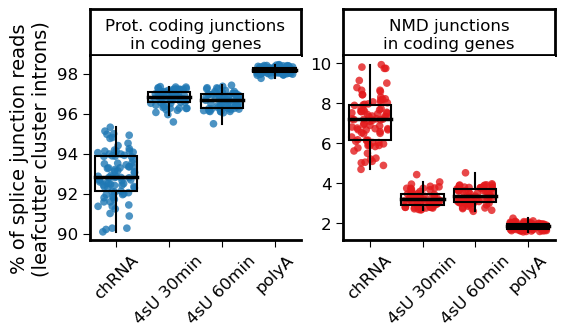

In [19]:
df_, order = longtable_to_boxplot(cluster_table)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = df_, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = df_, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

# sns.stripplot(data = df_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = df_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(leafcutter cluster introns)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.show()

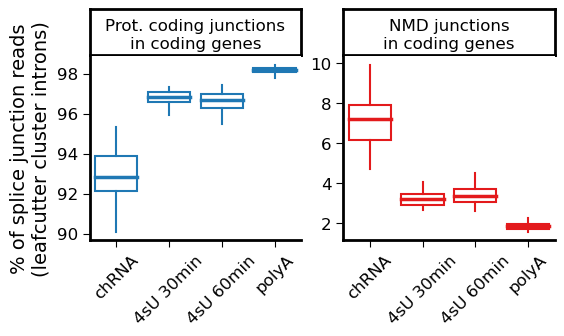

In [20]:
df_, order = longtable_to_boxplot(cluster_table)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

# sns.stripplot(data = df_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = df_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(leafcutter cluster introns)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.show()

Turns out that the junction reads distribution is very similar than when doing the regular mapping. This suggest that most of the differences between the 3% and the 7% figure likely are due to intron selection, rather than by the remapping itself.

No unannotated NMD


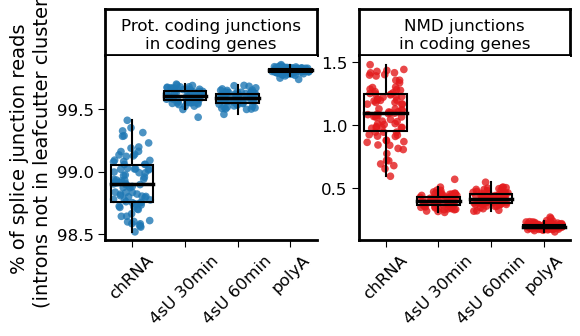

In [21]:
clu_excl = long_table.loc[~long_table.intron_coords.isin(cluster_table.intron_coords.unique())]
df_, order = longtable_to_boxplot(clu_excl)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})

sns.stripplot(data = df_, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = df_, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(introns not in leafcutter cluster)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.show()

No unannotated NMD


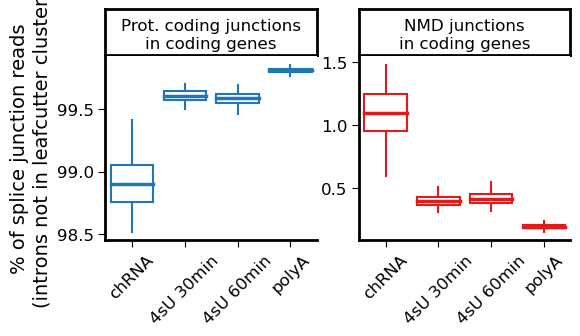

In [22]:
clu_excl = long_table.loc[~long_table.intron_coords.isin(cluster_table.intron_coords.unique())]
df_, order = longtable_to_boxplot(clu_excl)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})

sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(introns not in leafcutter cluster)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.show()

Non-leafcutter introns are more likely to be annotated in protein coding genes. These are probably just constitutive junctions in protein coding genes. As a result, the % of NMD junction reads is much lower in the group of junctions not in leafcutter clusters.

Thus overall I think that the 3% figure is closer to the truth.

In [23]:
percent_pc_not_in_cluster = (clu_excl.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene').mean()*100
percent_pc_in_leafcutter_cluster = (cluster_table.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene').mean()*100

In [24]:
# long_table.loc[~long_table.intron_coords.isin(cluster_table.intron_coords.unique())]

(cluster_table.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene').mean()

0.6917094781841822

In [25]:
(clu_excl.SuperAnnotation == 'UnannotatedJunc_ProductiveCodingGene').mean()

1.7023336278063344e-05

In [26]:
(clu_excl.SuperAnnotation == 'UnannotatedJunc_UnproductiveCodingGene').mean()

4.064260911970679e-05

In [27]:
(clu_excl.SuperAnnotation == 'AnnotatedJunc_UnproductiveCodingGene').mean()

0.04015446131446831

In [28]:
(clu_excl.SuperAnnotation == 'AnnotatedJunc_NoncodingGene').mean()

0.019641680596136867

In [29]:
(clu_excl.SuperAnnotation == 'UnannotatedJunc_NoncodingGene').mean()

8.244920704475124e-07

In [30]:
long_table.shape

(47701031, 16)

In [31]:
cluster_max_length = cluster_table.loc[cluster_table.SuperAnnotation.isin(
    ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']
)].groupby('cluster').intron_length.max()

def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

clu_1, clu_2, clu_3, clu_4 = get_series_quantile(cluster_max_length)

lt1 = cluster_table.loc[cluster_table.cluster.isin(clu_1)]
df1, order = longtable_to_boxplot(lt1)

lt2 = cluster_table.loc[cluster_table.cluster.isin(clu_2)]
df2, order = longtable_to_boxplot(lt2)

lt3 = cluster_table.loc[cluster_table.cluster.isin(clu_3)]
df3, order = longtable_to_boxplot(lt3)

lt4 = cluster_table.loc[cluster_table.cluster.isin(clu_4)]
df4, order = longtable_to_boxplot(lt4)

In [32]:
clu_df = pd.DataFrame()
unprod_juncs = list(df1.loc[df1.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df2.loc[df2.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df3.loc[df3.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df4.loc[df4.assay=='chRNA'].Unproductive_juncs)

clu_df['unprod_juncs'] = unprod_juncs
clu_df['length_quartile'] = ['Q1']*86 + ['Q2']*86 + ['Q3']*86 + ['Q4']*86

In [33]:
RPKM_median = RPKM[pd.Index(cluster_table.IndID.unique()).intersection(RPKM.columns)].median(axis=1)
rpkm_1, rpkm_2, rpkm_3, rpkm_4 = get_series_quantile(RPKM_median)


In [34]:
lt1 = long_table.loc[long_table.gene.isin(rpkm_1)]
df_rpkm1, order = longtable_to_boxplot(lt1)

lt2 = long_table.loc[long_table.gene.isin(rpkm_2)]
df_rpkm2, order = longtable_to_boxplot(lt2)

lt3 = long_table.loc[long_table.gene.isin(rpkm_3)]
df_rpkm3, order = longtable_to_boxplot(lt3)

lt4 = long_table.loc[long_table.gene.isin(rpkm_4)]
df_rpkm4, order = longtable_to_boxplot(lt4)

In [35]:
rpkm_df = pd.DataFrame()
unprod_juncs = list(df_rpkm1.loc[df_rpkm1.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm2.loc[df_rpkm2.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm3.loc[df_rpkm3.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm4.loc[df_rpkm4.assay=='chRNA'].Unproductive_juncs)

rpkm_df['unprod_juncs'] = unprod_juncs
rpkm_df['rpkm_quartile'] = ['Q1']*86 + ['Q2']*86 + ['Q3']*86 + ['Q4']*86

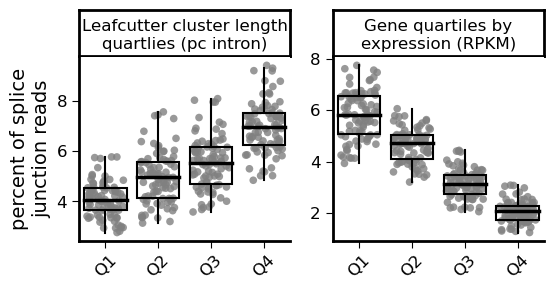

In [36]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data=clu_df, x='length_quartile', y='unprod_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data=clu_df, x='length_quartile', y='unprod_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

# sns.stripplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Leafcutter cluster length\nquartlies (pc intron)')
ax[1, 1].set_title('Gene quartiles by\nexpression (RPKM)')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.show()

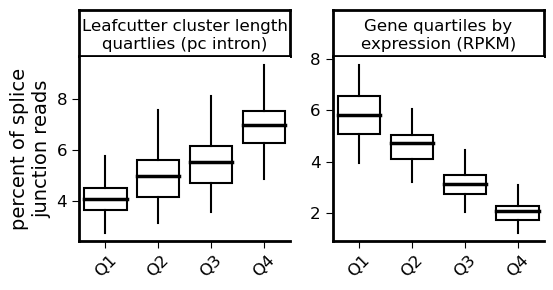

In [37]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


# sns.stripplot(data=clu_df, x='length_quartile', y='unprod_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
#               color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data=clu_df, x='length_quartile', y='unprod_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

# sns.stripplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
#               color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

# sns.stripplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Leafcutter cluster length\nquartlies (pc intron)')
ax[1, 1].set_title('Gene quartiles by\nexpression (RPKM)')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.show()

In [83]:
NMD_annot = ['UnannotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene']
pc_annot = ['UnannotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_ProductiveCodingGene']

NMD_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(NMD_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

pc_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(pc_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

In [121]:
genes_index = NMD_counts.index.intersection(pc_counts.index)

In [122]:
chRNA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]
polyA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/Expression.Splicing.Subset_YRI/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]

In [123]:
chRNA_log2RPKM = np.log2(np.exp(chRNA_RPKM[chRNA_RPKM.columns[5:]].median(axis=1)))
polyA_log2RPKM = np.log2(np.exp(polyA_RPKM[polyA_RPKM.columns[5:]].median(axis=1)))

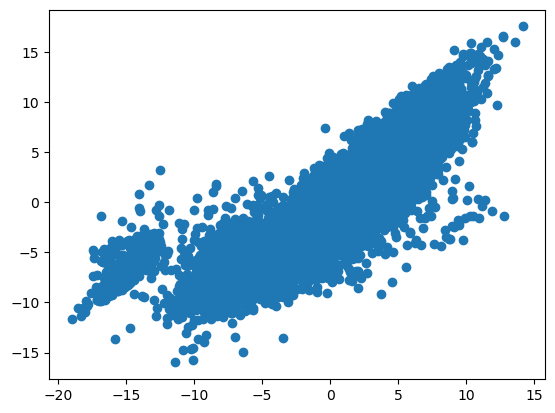

In [124]:
plt.scatter(chRNA_log2RPKM, polyA_log2RPKM)

In [130]:
chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(genes_index).intersection(polyA_genes)

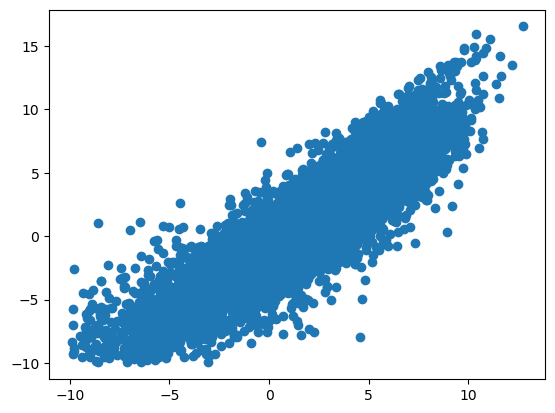

In [131]:
plt.scatter(chRNA_log2RPKM.loc[genes_index], polyA_log2RPKM.loc[genes_index])

In [132]:
total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts

In [138]:
NMD_percent.mean(axis=1)

ENSG00000188976.11    0.030217
ENSG00000187961.14    0.074475
ENSG00000187583.11    0.012371
ENSG00000188290.11    0.024311
ENSG00000188157.15    0.003661
                        ...   
ENSG00000148399.13    0.251680
ENSG00000165724.6     0.058806
ENSG00000197070.14    0.009169
ENSG00000181090.21    0.031994
ENSG00000148408.13    0.015517
Length: 9486, dtype: float64

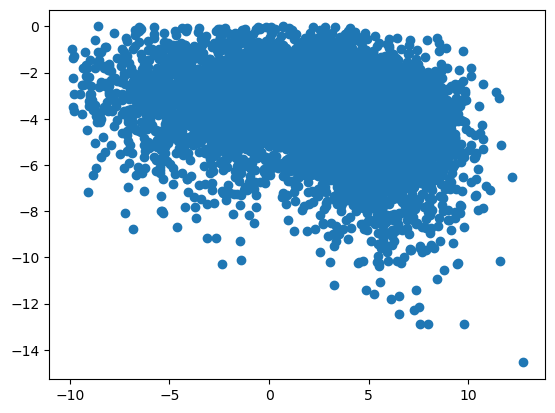

In [140]:
plt.scatter(chRNA_log2RPKM.loc[genes_index], np.log(NMD_percent.mean(axis=1)))

In [142]:
pearsonr(chRNA_log2RPKM.loc[genes_index], np.log(NMD_percent.mean(axis=1)))

PearsonRResult(statistic=-0.2643863037350019, pvalue=1.810923266666482e-151)

In [143]:
pearsonr(polyA_log2RPKM.loc[genes_index], np.log(NMD_percent.mean(axis=1)))

PearsonRResult(statistic=-0.36632452591700293, pvalue=3.967600187716975e-299)

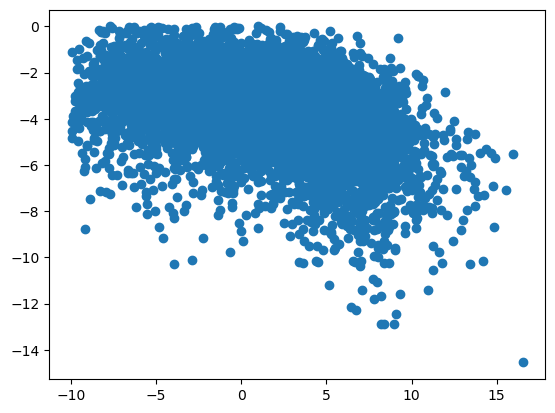

In [144]:
plt.scatter(polyA_log2RPKM.loc[genes_index], np.log(NMD_percent.mean(axis=1)))

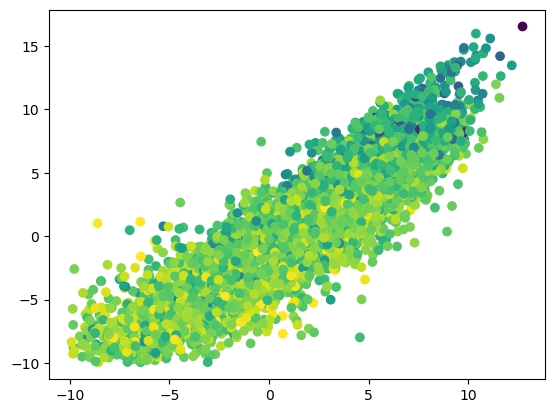

In [145]:
plt.scatter(chRNA_log2RPKM.loc[genes_index], polyA_log2RPKM.loc[genes_index], c=np.log(NMD_percent.mean(axis=1)))

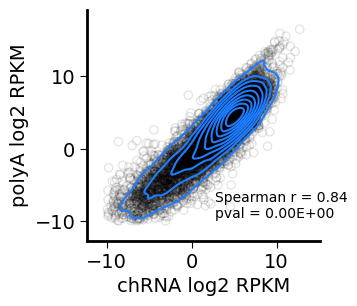

In [171]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3,3))

plot_correlation(chRNA_log2RPKM.loc[genes_index], polyA_log2RPKM.loc[genes_index],
                 contour_color='#1e7cff', ylabel='polyA log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax, xy=(0.55, 0.1), **kwargs)

# plt.plot([-15, 12], [-5, -5], 'r--')
# plt.plot([-5, -5], [-15, 12], 'r--')
# ax.plot([-15, 15], [-15, 15], 'r--')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
ax.set_xlabel('chRNA log2 RPKM', size=14)
ax.set_ylabel('polyA log2 RPKM', size=14)

plt.show()

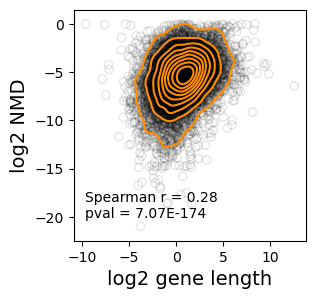

In [169]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3, 3))

plot_correlation(chRNA_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index], 
                 np.log2(NMD_percent.mean(axis=1)),
                 contour_color='darkorange', ylabel='log2 NMD', 
                 xlabel='log2 gene length', ax=ax, **kwargs)

plt.show()
# plt.savefig(figdir + 'supplementary_figures/Fig2C_gene_NMD.png', bbox_inches='tight', dpi=300)
# plt.savefig(figdir + 'supplementary_figures/Fig2C_gene_NMD.pdf', bbox_inches='tight', dpi=300)

In [154]:
import sys

sys.path.append('../code/scripts/useful_modules')

# Some useful functions for plotting that I wrote previously
from plot_functions import *
from regression_functions import *

In [193]:
chRNA_juncs_NMD_ratio = np.log(NMD_percent.loc[genes_index].mean(axis=1))
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
chRNA_polyA_log2_difference = chRNA_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]

In [165]:
def plot_cumulative_quantiles(X, quantile_list, color_list, label_list = None,
                               method='median', ax=None, plot_legend = False, norm_to_Q1 = False, 
                               **kwargs):
    for i in range(len(quantile_list)):
        Qi = quantile_list[i]
        color = color_list[i]
        
        if label_list is None:
            label = 'Q' + str(i+1)
        else:
            label = label_list[i]
            
#         if method == '':
#             for j in X.columns:
#                 X_to_plot = X.loc[Qi, j]
#                 plot_cumulative(X_to_plot, c=color, ax=ax, alpha=0.4)
#             continue
        
#         elif method == 'median':
#             X_to_plot = np.array(X.loc[Qi].median(axis=1))
            
            
#         elif method == 'mean':
        X_to_plot = np.array(X.loc[Qi])
            
        if norm_to_Q1:
            if i == 0:
                Q1_ = X_to_plot
                continue
            else:
                X_to_plot = X_to_plot/Q1_

        plot_cumulative(X_to_plot, c=color, ax=ax, label=label)
            
        
                
    if ax:
        if plot_legend:
            if 'legend_title' in kwargs:
                ax.legend(title = kwargs['legend_title'], frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                ax.legend(frameon=False,
                         loc='center left', bbox_to_anchor=(1, 0.5))
        if 'xlim' in kwargs:
            ax.set_xlim(kwargs['xlim'])
        if 'ylim' in kwargs:
            ax.set_ylim(kwargs['ylim'])
        if 'xticks' in kwargs:
            ax.set_xticks(kwargs['xticks'])
        if 'xticklabels' in kwargs:
            ax.set_xticklabels(kwargs['xticklabels'])
        if 'yticks' in kwargs:
            ax.set_yticks(kwargs['yticks'])
        if 'yticklabels' in kwargs:
            ax.set_yticklabels(kwargs['yticklabels'])
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #ax.tick_params(size=4, width=2, labelsize=kwargs['fontsize'])
        if 'vertical_line_at' in kwargs:
            ax.plot([kwargs['vertical_line_at'], kwargs['vertical_line_at']], 
                    [0, 1], linestyle='--', c='gray')
        if 'xlabel' in kwargs:
            ax.set_xlabel(kwargs['xlabel'], fontsize=kwargs['fontsize'])
        if 'ylabel' in kwargs:
            ax.set_ylabel(kwargs['ylabel'], fontsize=kwargs['fontsize'])
        if 'title' in kwargs:
            ax.set_title(kwargs['title'], fontsize=kwargs['fontsize'])


Text(0.5, 0, 'log2FC RPKM\nchRNA - polyA')

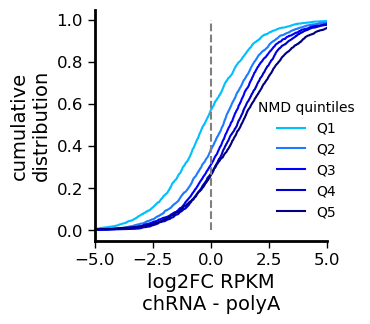

In [214]:

figsize = (3, 3)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['deepskyblue', '#1e7cff', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax,
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   legend_title = '%NMD quintiles',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=16, label_list = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], method='')

ax.legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(0.65, 0.35), 
          fontsize=10, title_fontsize = 10)
ax.tick_params(length=5, labelsize=12, width=1)


ax.set_ylabel('cumulative\ndistribution',size=14)
ax.set_xlabel('log2FC RPKM\nchRNA - polyA',size=14)

# xlabel='log2FC RPKM\nchRNA - polyA',


In [190]:
# We get H3K36ME3 coverage over the gene body
h3k36me3_logRPKM = pd.read_csv(
    '../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

h3k36me3_logRPKM = h3k36me3_logRPKM[h3k36me3_logRPKM.columns[5:]]

# Get log2 fold difference
h3k36me3_log2RPKM = h3k36me3_logRPKM.loc[genes_idx]*np.log2(np.e)
h3k36me3_polyA_log2_difference = h3k36me3_log2RPKM.median(axis=1) - polyA_log2RPKM


# For H3K4ME3, it's a bit trickier. We get the CPM of the peaks that are close (within 2000 bp) of
# a TSS for each gene


In [189]:
H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz',#'../../H3K4ME3.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = H3K4ME3.columns[5:]
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]

h3k4me3_idx = genes_idx.intersection(h3k4me3_CPM.index)
h3k4me3_log2RPKM = np.log2(h3k4me3_CPM.loc[h3k4me3_idx]) 
h3k4me3_log2RPKM = h3k4me3_log2RPKM.loc[h3k4me3_log2RPKM.median(axis=1) > -1e100]
h3k4me3_idx = h3k4me3_log2RPKM.index
h3k4me3_polyA_log2_difference = h3k4me3_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k4me3_idx]


In [188]:


H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = H3K27AC.columns[5:]
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]

h3k27ac_idx = genes_idx.intersection(h3k27ac_CPM.index)
h3k27ac_log2RPKM = np.log2(h3k27ac_CPM.loc[h3k27ac_idx]) 
h3k27ac_log2RPKM = h3k27ac_log2RPKM.loc[h3k27ac_log2RPKM.median(axis=1) > -1e100]
h3k27ac_idx = h3k27ac_log2RPKM.index
h3k27ac_polyA_log2_difference = h3k27ac_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k27ac_idx]

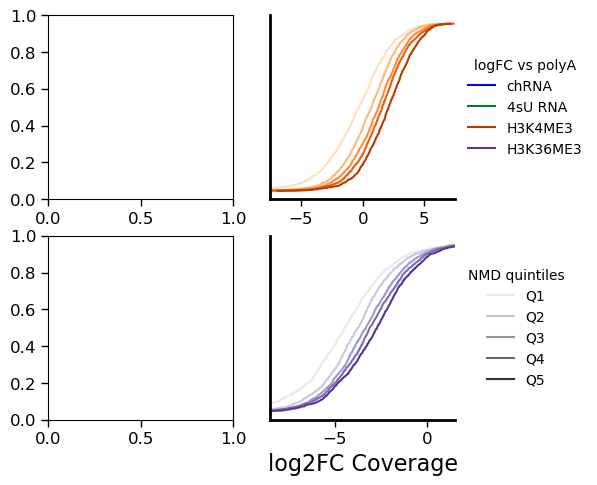

In [209]:
# chRNA vs polyA, K4ME3 vs polyA, and K36ME3 vs polyA; 4sU vs polyA

h3k4me3_idx = h3k4me3_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k27ac_idx = h3k27ac_idx.intersection(chRNA_juncs_NMD_ratio.index)

h3k36me3_idx = h3k36me3_polyA_log2_difference.dropna().index.intersection(chRNA_juncs_NMD_ratio.index)

figsize = (5.25, 5.25)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.2}, figsize=figsize)

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx], quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx], quant=5)
NMD_ratio_quant_all_h3k36me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k36me3_idx], quant=5)



# plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
# #                           sns.color_palette("Blues", 10),
#                                    ['deepskyblue', '#1e7cff', 'blue', 'mediumblue', 'navy'], 
#                                    ax=ax[0, 0],
#                                    ylabel='cumulative\ndistribution',
#                                    xlabel='log2FC RPKM\nchRNA - polyA',
#                                    legend_title = '%NMD quintiles',
#                                    vertical_line_at = 0, xlim=[-5, 5],
#                                    fontsize=16)

# plot_cumulative_quantiles(ml30_polyA_log2_difference, NMD_ratio_quant_all_genes, 
#                     sns.color_palette("Greens", 5), xlim=[-5, 5], ax=ax[1, 0],
#                           ylabel='cumulative\ndistribution',
#                           vertical_line_at = 0,
# #                            ylabel='4sU RNA - polyA\ncumulative distribution',
#                    xlabel = 'log2FC RPKM', legend_title = '%NMD quintiles', fontsize=16,
#                          label_list = [None, None, None, None, None])

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference.loc[h3k4me3_idx], NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Oranges", 5), xlim=[-7.5,7.5], ax=ax[0, 1],
#                           vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2FC RPKM', legend_title = '%NMD quintiles', fontsize=16)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
                    sns.color_palette("Purples", 5), xlim=[-8.5,1.5], ax=ax[1, 1],
#                           vertical_line_at = 0,
#                           ylabel='H3K36ME3 - polyA\ncumulative distribution',
                   xlabel = 'log2FC Coverage', legend_title = '%NMD quintiles', fontsize=16,
                         label_list = [None, None, None, None, None])

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])
ax[0,1].set_xlabel("")
ax[0,0].set_xlabel("")

ax[0,1].plot([-50], [0.5], c = 'blue', label = 'chRNA')
ax[0,1].plot([-50], [0.5], c = sns.color_palette("Greens", 5)[4], label = '4sU RNA')
ax[0,1].plot([-50], [0.5], c = sns.color_palette("Oranges", 5)[4], label = 'H3K4ME3')
ax[0,1].plot([-50], [0.5], c = sns.color_palette("Purples", 5)[4], label = 'H3K36ME3')

ax[0,1].legend(title = 'logFC vs polyA', frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[1,1].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[1,1].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))

ax[0,0].tick_params(length=5, labelsize=12, width=1)
ax[1,0].tick_params(length=5, labelsize=12, width=1)
ax[0,1].tick_params(length=5, labelsize=12, width=1)
ax[1,1].tick_params(length=5, labelsize=12, width=1)


plt.show()
# plt.savefig(figdir + 'supplementary_figures/Fig1.coverage_distribution.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'supplementary_figures/Fig1.coverage_distribution.png', dpi=300, bbox_inches='tight',)

In [200]:
h3k36me3_polyA_log2_difference.dropna()

pid
ENSG00000000419.12   -6.536026
ENSG00000000457.14   -0.317682
ENSG00000000460.17   -3.684365
ENSG00000000938.13   -4.122309
ENSG00000001036.14   -4.660237
                        ...   
ENSG00000284976.1    -0.215536
ENSG00000286169.1    -0.829252
ENSG00000287080.2    -1.188006
ENSG00000287725.1    -2.883774
ENSG00000288596.1    -0.235973
Length: 9394, dtype: float64

In [191]:
h3k36me3_polyA_log2_difference

pid
ENSG00000000419.12   -6.536026
ENSG00000000457.14   -0.317682
ENSG00000000460.17   -3.684365
ENSG00000000938.13   -4.122309
ENSG00000001036.14   -4.660237
                        ...   
ENSG00000287080.2    -1.188006
ENSG00000287725.1    -2.883774
ENSG00000288534.1          NaN
ENSG00000288593.1          NaN
ENSG00000288596.1    -0.235973
Length: 14000, dtype: float64